# Analysis of segments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py
from pm4py.discovery import discover_petri_net_inductive
from pm4py.conformance import fitness_token_based_replay
from pm4py.conformance import precision_token_based_replay

In [2]:
# Load the XES files and convert them to DataFrames
df_PTC = pm4py.convert_to_dataframe(pm4py.read_xes('../datasets_segmented/PrepaidTravelCost_segmented.xes'))
df_RFP = pm4py.convert_to_dataframe(pm4py.read_xes('../datasets_segmented/RequestForPayments_segmented.xes'))
df_ID = pm4py.convert_to_dataframe(pm4py.read_xes('../datasets_segmented/InternationalDeclarations_segmented.xes'))
df_PL = pm4py.convert_to_dataframe(pm4py.read_xes('../datasets_segmented/PermitLog_segmented.xes'))
df_DD = pm4py.convert_to_dataframe(pm4py.read_xes('../datasets_segmented/DomesticDeclarations_segmented.xes'))

parsing log, completed traces ::   0%|          | 0/1548 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6039 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/4457 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/4833 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/9403 [00:00<?, ?it/s]

In [3]:
# Store dataframe in a dictionary for easier iteration
all_dfs = {
    "PrepaidTravelCost": df_PTC,
    "RequestForPayments": df_RFP,
    "InternationalDeclarations": df_ID,
    "PermitLog": df_PL,
    "DomesticDeclarations": df_DD
}

# Reverse map for plotting labels
numeric_to_role_map = {
    0: 'UNDEFINED',
    1: 'EMPLOYEE',
    2: 'SUPERVISOR',
    3: 'ADMINISTRATION',
    4: 'BUDGET OWNER',
    5: 'DIRECTOR',
    6: 'PRE_APPROVER',
}

## Case duration analysis

Case Duration Analysis

Overall Duration Summary Across All Logs and Segments
                          Log  Role_Numeric       Role_Name  Mean_Duration_Days  Median_Duration_Days  Case_Count_in_Segment
18                  PermitLog             0       UNDEFINED           87.425167             72.018449                  10957
19                  PermitLog             1        EMPLOYEE           80.384926             65.729954                  21067
21                  PermitLog             3  ADMINISTRATION           78.401220             65.260521                   9387
20                  PermitLog             2      SUPERVISOR           79.094697             64.072199                   9391
22                  PermitLog             4    BUDGET OWNER           75.409956             62.112118                   2449
17  InternationalDeclarations             4    BUDGET OWNER           72.054542             61.122535                   2669
14  InternationalDeclarations             1    

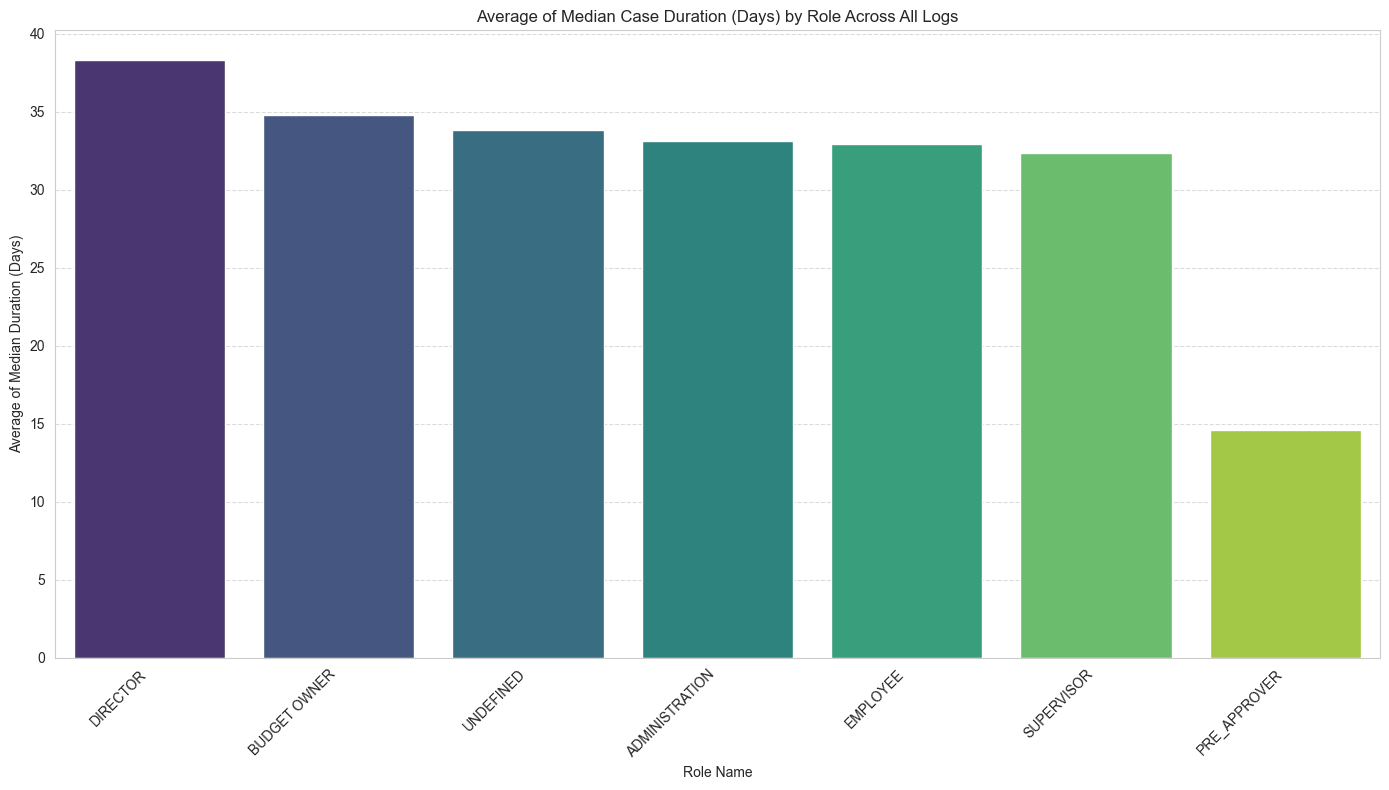

In [12]:
# Case duration analysis
print("Case Duration Analysis")

# List to store summary data for easier comparison
summary_data = []

# Iteration through each DataFrame and perform analysis
for log_name, df in all_dfs.items():
    
    # Calculate overall log duration metrics
    overall_mean_duration = df['case_duration_days'].mean()
    overall_median_duration = df['case_duration_days'].median()

    # Group by the numeric role and calculate metrics for each segment
    segment_duration_stats = df.groupby('org_role_numeric')['case_duration_days'].agg(['mean', 'median', 'count']).reset_index()
    
    # Add role names for better readability
    segment_duration_stats['org_role_name'] = segment_duration_stats['org_role_numeric'].map(numeric_to_role_map)

    # Store summary data for overall comparison
    for _, row in segment_duration_stats.iterrows():
        summary_data.append({
            'Log': log_name,
            'Role_Numeric': row['org_role_numeric'],
            'Role_Name': row['org_role_name'],
            'Mean_Duration_Days': row['mean'],
            'Median_Duration_Days': row['median'],
            'Case_Count_in_Segment': row['count']
        })
        
# Overall Comparison Table, creating a DataFrame from the summary data
overall_duration_summary_df = pd.DataFrame(summary_data)
print("\nOverall Duration Summary Across All Logs and Segments")

# Sort by median duration and display
print(overall_duration_summary_df.sort_values(by='Median_Duration_Days', ascending=False).to_string())

# Group by Role Name across all logs, aggregating the metrics
print("\n\nStatistics per role across all Logs:\n")

role_stats = overall_duration_summary_df.groupby('Role_Name').agg(
    Avg_of_Median_Duration_Days=('Median_Duration_Days', 'mean'), 
    Avg_of_Mean_Duration_Days=('Mean_Duration_Days', 'mean'),     
    Total_Cases_Associated=('Case_Count_in_Segment', 'sum')   
).reset_index()

# Sort for easier interpretation and display
role_stats = role_stats.sort_values(by='Avg_of_Median_Duration_Days', ascending=False)
print(role_stats.to_string(index=False))

# Plotting the average of median case duration by role across all logs
plt.figure(figsize=(14, 8))
sns.barplot(x='Role_Name', y='Avg_of_Median_Duration_Days', data=role_stats, palette='viridis', hue='Role_Name', legend=False)
plt.title('Average of Median Case Duration (Days) by Role Across All Logs')
plt.xlabel('Role Name')
plt.ylabel('Average of Median Duration (Days)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()    

## Case size analysis


Case Size Analysis

Overall Case Size Summary Across All Logs and Segments
                          Log  Role_Numeric       Role_Name  Mean_Case_Size  Median_Case_Size  Case_Count_in_Segment
22                  PermitLog             4    BUDGET OWNER       12.755002              12.0                   2449
21                  PermitLog             3  ADMINISTRATION       12.942687              12.0                   9387
19                  PermitLog             1        EMPLOYEE       12.012199              12.0                  21067
18                  PermitLog             0       UNDEFINED       12.531259              12.0                  10957
17  InternationalDeclarations             4    BUDGET OWNER       12.691645              12.0                   2669
16  InternationalDeclarations             3  ADMINISTRATION       11.737246              12.0                   8605
20                  PermitLog             2      SUPERVISOR       12.162602              11.0            

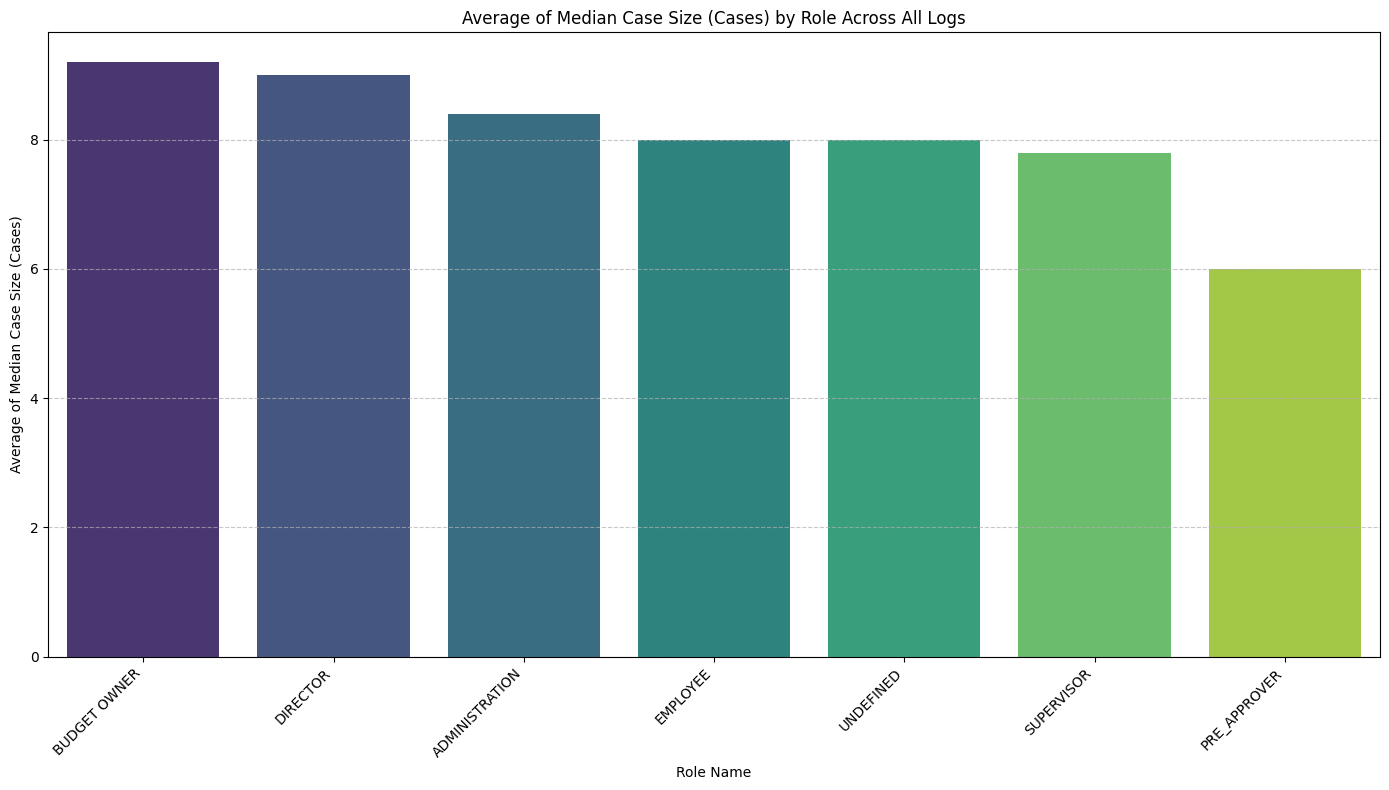

In [6]:
# Case Size Analysis
print("\nCase Size Analysis")

# List to store summary data for easier comparison
summary_data_case_size = []

# Iteration through each DataFrame and perform analysis
for log_name, df in all_dfs.items():

    # Calculate case size for each case, mergeing the size back into the DataFrame
    case_sizes_series = df.groupby('case:id').size().rename('case_size')
    df_with_case_size = df.merge(case_sizes_series.reset_index(), on='case:id', how='left')

    # Calculate overall log case size metrics
    unique_case_sizes_for_overall = df_with_case_size.drop_duplicates(subset=['case:id'])['case_size']
    overall_mean_case_size = unique_case_sizes_for_overall.mean()
    overall_median_case_size = unique_case_sizes_for_overall.median()

    # Group by the numeric role and calculate case size metrics for each segment.
    segment_case_size_stats = df_with_case_size.groupby('org_role_numeric')['case_size'].agg(
        mean='mean',
        median='median',
        count='count'
    ).reset_index()
    
    # Add role names
    segment_case_size_stats['org_role_name'] = segment_case_size_stats['org_role_numeric'].map(numeric_to_role_map)

    # Store summary data for overall comparison
    for _, row in segment_case_size_stats.iterrows():
        summary_data_case_size.append({
            'Log': log_name,
            'Role_Numeric': row['org_role_numeric'],
            'Role_Name': row['org_role_name'],
            'Mean_Case_Size': row['mean'],
            'Median_Case_Size': row['median'],
            'Case_Count_in_Segment': row['count']
        })
            
# Overall Comparison Table, creating a DataFrame from the summary data
overall_case_size_summary_df = pd.DataFrame(summary_data_case_size)
print("\nOverall Case Size Summary Across All Logs and Segments")

# Sort by median case size and display
print(overall_case_size_summary_df.sort_values(by='Median_Case_Size', ascending=False).to_string())

# Group by Role Name across all logs, aggregating the metrics
print("\n\nStatistics per Role across all logs:\n")
consolidated_role_size_stats = overall_case_size_summary_df.groupby('Role_Name').agg(
    Avg_of_Median_Case_Size=('Median_Case_Size', 'mean'),
    Avg_of_Mean_Case_Size=('Mean_Case_Size', 'mean'),
    Total_Cases_Associated=('Case_Count_in_Segment', 'sum')
).reset_index()

# Sort for easier interpretation and display
consolidated_role_size_stats = consolidated_role_size_stats.sort_values(by='Avg_of_Median_Case_Size', ascending=False)
print(consolidated_role_size_stats.to_string(index=False))

# Plotting the average of median case size by role across all logs
plt.figure(figsize=(14, 8))
sns.barplot(x='Role_Name', y='Avg_of_Median_Case_Size', data=consolidated_role_size_stats, palette='viridis', hue='Role_Name', legend=False)
plt.title('Average of Median Case Size (Cases) by Role Across All Logs')
plt.xlabel('Role Name')
plt.ylabel('Average of Median Case Size (Cases)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Reworked activities

Rework statistics per role across all logs:

     Role_Name  Avg_Percentage_Cases_with_Rework_by_Role  Total_Rework_Cases_Associated  Total_Cases_Involved_Overall
     UNDEFINED                                 38.712465                           1792                          4629
      EMPLOYEE                                 13.184024                           2520                         20241
ADMINISTRATION                                  5.753504                            484                          8275
    SUPERVISOR                                  3.993379                            193                          4833
  BUDGET OWNER                                  1.544944                             22                          1424


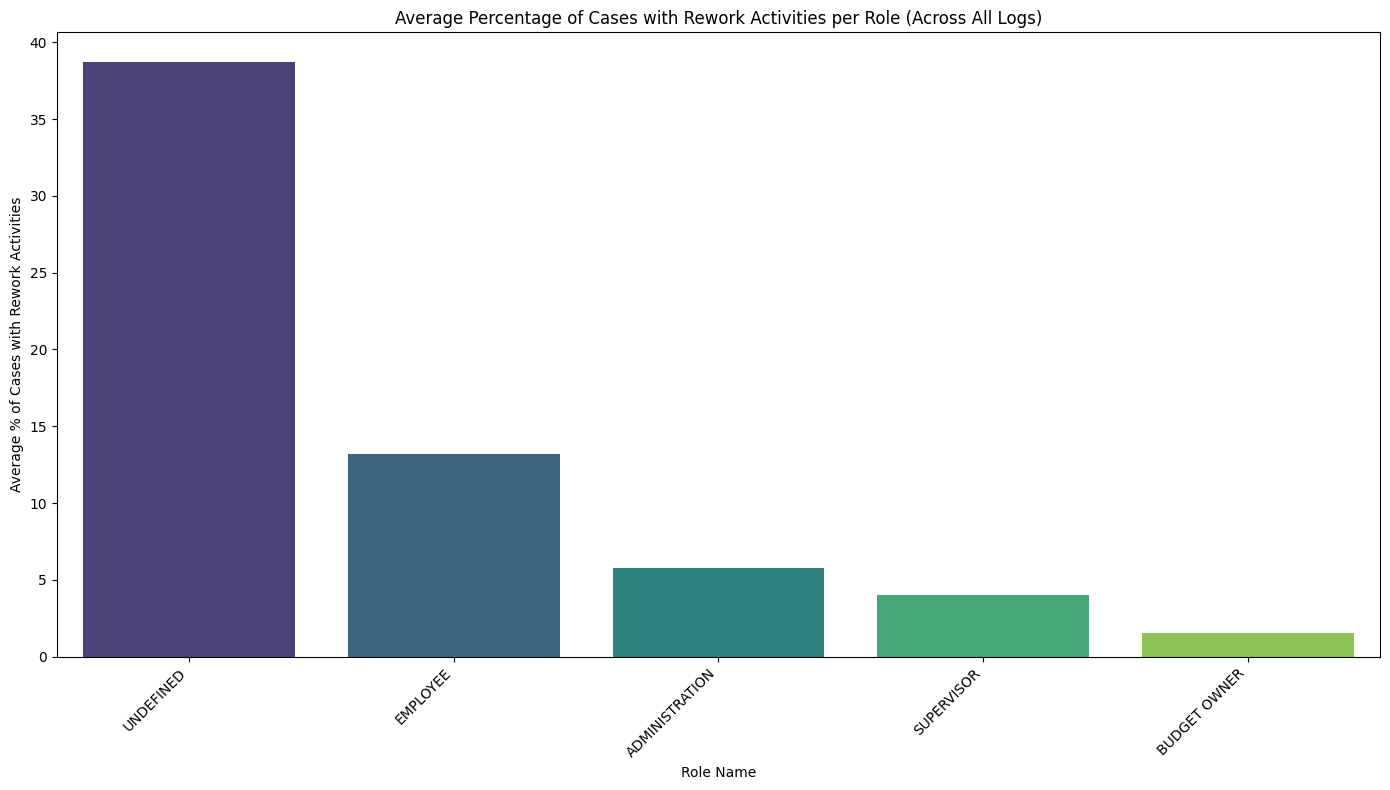

In [ ]:
# Rework Analysis

# List to store summary data
summary_data_rework = []

# Iteration through each DataFrame
for log_name, df in all_dfs.items():
 
    # Get the rework cases per activity
    rework_per_activity = pm4py.stats.get_rework_cases_per_activity(
        df,
        activity_key='concept:name',
        case_id_key='case:id',
        timestamp_key='time:timestamp'
    )
    
    # Convert the rework cases dictionary to a DataFrame
    rework_df = pd.DataFrame.from_dict(rework_per_activity, orient='index', columns=['cases_with_rework_for_activity']).reset_index()
    rework_df.rename(columns={'index': 'concept:name'}, inplace=True)
    activity_role_mapping = df[['concept:name', 'org_role_numeric']].drop_duplicates().dropna(subset=['org_role_numeric'])
    rework_by_activity_and_role = rework_df.merge(activity_role_mapping, on='concept:name', how='left')
    
    # Compute rework statistics per role
    rework_stats_per_role = rework_by_activity_and_role.groupby('org_role_numeric').agg(
        total_cases_with_rework_activities=('cases_with_rework_for_activity', 'sum')
    ).reset_index()
    total_cases_involved_per_role = df.groupby('org_role_numeric')['case:id'].nunique().reset_index(name='total_cases_involved')
    rework_stats_per_role = rework_stats_per_role.merge(total_cases_involved_per_role, on='org_role_numeric', how='left').fillna(0)
    rework_stats_per_role['percentage_cases_with_rework_by_role'] = (rework_stats_per_role['total_cases_with_rework_activities'] / rework_stats_per_role['total_cases_involved']) * 100
    rework_stats_per_role['Role_Name'] = rework_stats_per_role['org_role_numeric'].map(numeric_to_role_map)
    
    # Iterate through the rework statistics and append to summary data
    for _, row in rework_stats_per_role.iterrows():
        summary_data_rework.append({
            'Log': log_name,
            'Role_Numeric': row['org_role_numeric'],
            'Role_Name': row['Role_Name'],
            'Total_Cases_with_Rework_Activities_for_Role': row['total_cases_with_rework_activities'],
            'Total_Cases_Involved_for_Role': row['total_cases_involved'],
            'Percentage_Cases_with_Rework_by_Role': row['percentage_cases_with_rework_by_role']
        })

overall_rework_summary_df = pd.DataFrame(summary_data_rework)
print("Rework statistics per role across all logs:\n")

# Aggregate the rework statistics across all logs
consolidated_rework_stats = overall_rework_summary_df.groupby('Role_Name').agg(
    Avg_Percentage_Cases_with_Rework_by_Role=('Percentage_Cases_with_Rework_by_Role', 'mean'),
    Total_Rework_Cases_Associated=('Total_Cases_with_Rework_Activities_for_Role', 'sum'),
    Total_Cases_Involved_Overall=('Total_Cases_Involved_for_Role', 'sum')
).reset_index()

# Sorting
consolidated_rework_stats = consolidated_rework_stats.sort_values(by='Avg_Percentage_Cases_with_Rework_by_Role', ascending=False)

# Display
print(consolidated_rework_stats.to_string(index=False))

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Role_Name', y='Avg_Percentage_Cases_with_Rework_by_Role', data=consolidated_rework_stats, palette='viridis', hue='Role_Name', legend=False)
plt.title('Average Percentage of Cases with Rework Activities per Role (Across All Logs)')
plt.xlabel('Role Name')
plt.ylabel('Average % of Cases with Rework Activities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Conformance Checking

Conformance Checking Analysis using Inductive Miner Petri Net and Token-Based Replay

Analyzing Log: PrepaidTravelCost


replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/55 [00:00<?, ?it/s]


Analyzing Log: RequestForPayments


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]


Analyzing Log: InternationalDeclarations


replaying log with TBR, completed traces ::   0%|          | 0/204 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/977 [00:00<?, ?it/s]


Analyzing Log: PermitLog


replaying log with TBR, completed traces ::   0%|          | 0/431 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2845 [00:00<?, ?it/s]


Analyzing Log: DomesticDeclarations


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/18 [00:00<?, ?it/s]


Overall conformance Summary Across all logs:

                      Log  Fitness  Precision
       RequestForPayments      1.0   1.000000
     DomesticDeclarations      1.0   0.983918
InternationalDeclarations      1.0   0.787720
        PrepaidTravelCost      1.0   0.629873
                PermitLog      1.0   0.267766


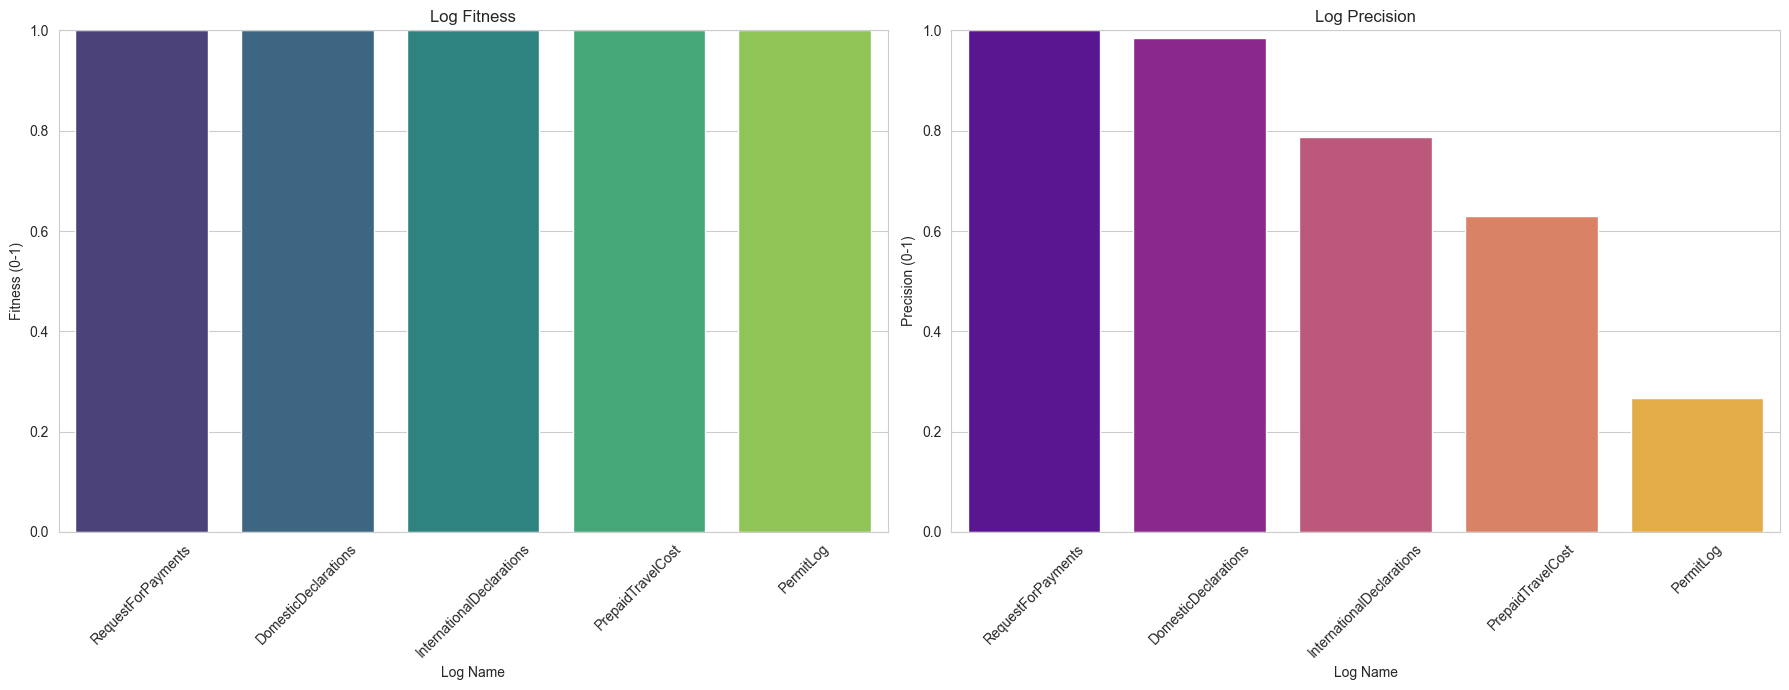

In [8]:
# Conformance Checking Analysis using Inductive Miner Petri Net and Token-Based Replay

sns.set_style("whitegrid")
print("Conformance Checking Analysis using Inductive Miner Petri Net and Token-Based Replay")
summary_conformance_data = []

for log_name, df in all_dfs.items():
    print(f"\nAnalyzing Log: {log_name}")
    
    # Convert DataFrame to Event Log
    log = pm4py.convert_to_event_log(df, case_id_key='case:id', activity_key='concept:name', timestamp_key='time:timestamp')

    # Discover the Petri net using Inductive Miner
    net, im, fm = discover_petri_net_inductive(log) 
    
    # Fitness computation using fitness_token_based_replay
    fitness_score = None
    fitness_results = fitness_token_based_replay(log, net, im, fm)
    if isinstance(fitness_results, dict) and 'log_fitness' in fitness_results: # Avoid potential KeyError
        fitness_score = fitness_results['log_fitness']

    # Precision computation using precision_token_based_replay
    precision_score = None
    precision_score = precision_token_based_replay(log, net, im, fm)
    if isinstance(precision_score, dict) and 'precision' in precision_score: # Avoid potential KeyError
        precision_score = precision_score['precision']
    
    # Summary
    summary_conformance_data.append({
        'Log': log_name,
        'Fitness': fitness_score,
        'Precision': precision_score
    })

# DataFrame for overall conformance summary, displaying fitness and precision scores
overall_conformance_df = pd.DataFrame(summary_conformance_data)
overall_conformance_df = overall_conformance_df.sort_values(by='Precision', ascending=False)
print("\nOverall conformance Summary Across all logs:\n")
print(overall_conformance_df.to_string(index=False))

# Plotting the conformance results
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Fitness Plot
sns.barplot(x='Log', y='Fitness', data=overall_conformance_df, palette='viridis', hue='Log', legend=False, ax=axes[0])
axes[0].set_title('Log Fitness')
axes[0].set_xlabel('Log Name')
axes[0].set_ylabel('Fitness (0-1)')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45) 

# Precision Plot
sns.barplot(x='Log', y='Precision', data=overall_conformance_df, palette='plasma', hue='Log', legend=False, ax=axes[1])
axes[1].set_title('Log Precision')
axes[1].set_xlabel('Log Name')
axes[1].set_ylabel('Precision (0-1)')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)
 
plt.tight_layout()
plt.show()

# Rejection rates

Overall rejection summary across all logs:

                 Log_Name  Unique_Cases_with_Rejection  Percentage_Cases_with_Rejection_in_Log  Total_Rejected_Activities           Involved_Roles
InternationalDeclarations                          957                               21.471842                       2263 ADMINISTRATION, EMPLOYEE
                PermitLog                          818                               16.925305                       2006 ADMINISTRATION, EMPLOYEE
       RequestForPayments                          343                                5.679748                        686 ADMINISTRATION, EMPLOYEE
     DomesticDeclarations                          345                                3.669042                        690 ADMINISTRATION, EMPLOYEE
        PrepaidTravelCost                           53                                3.423773                        106 ADMINISTRATION, EMPLOYEE


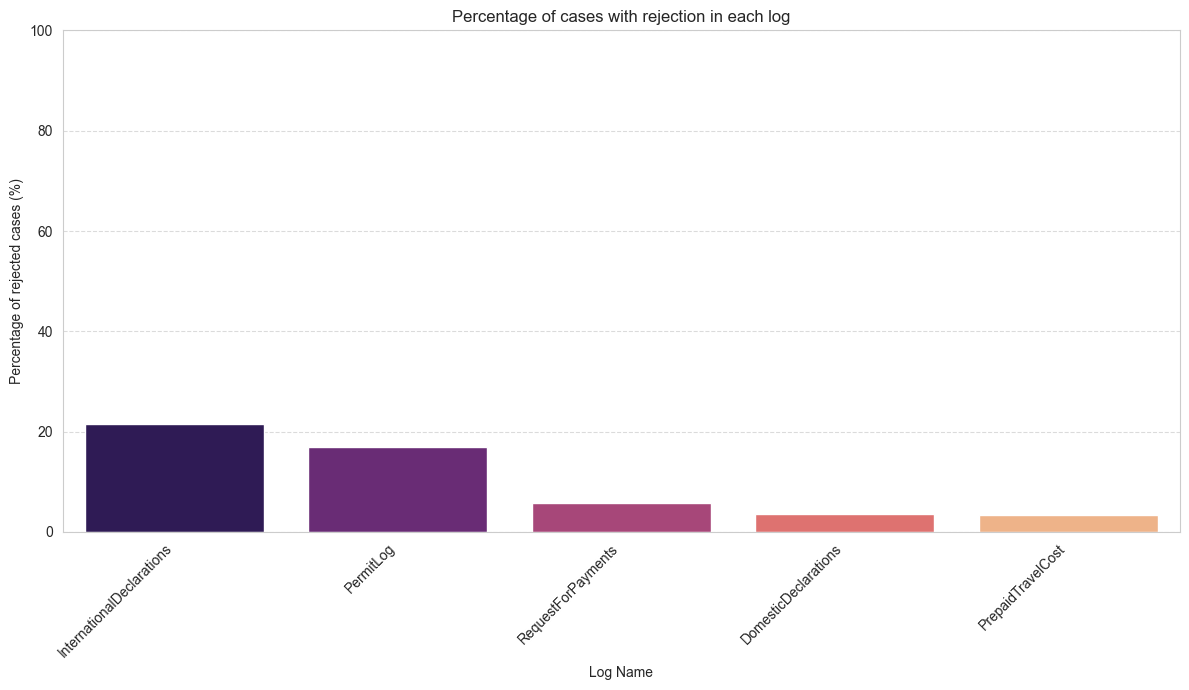

In [ ]:
#Rejection rates and involved roles analysis

rejected_cases_summary_list = []

# Iteration through each Dataframe
for log_name, df_log in all_dfs.items():
    
    # Preprocess the DataFrame to ensure correct types, create a copy to avoid modifying the original
    df_log_processed = df_log.copy()
    df_log_processed['concept:name'] = df_log_processed['concept:name'].astype(str)
    df_log_processed['org_role_numeric'] = pd.to_numeric(df_log_processed['org_role_numeric'], errors='coerce').fillna(-1).astype(int)

    # Filter the DataFrame for activities that contain 'REJECTED'
    rejected_activities_in_log = df_log_processed[df_log_processed['concept:name'].str.contains('REJECTED', na=False)]

    # If there are rejected activities in the log
    if not rejected_activities_in_log.empty:

        # Calculate some statistics
        unique_rejected_cases = rejected_activities_in_log['case:id'].nunique()
        total_cases_in_log = df_log_processed['case:id'].nunique()
        percentage_cases_with_rejection = (unique_rejected_cases / total_cases_in_log) * 100 
        involved_roles_numeric = rejected_activities_in_log['org_role_numeric'].unique()
        involved_roles_names = [numeric_to_role_map.get(role_num, 'UNKNOWN_ROLE') for role_num in involved_roles_numeric]
        involved_roles_str = ', '.join(sorted(set(involved_roles_names)))
        total_rejected_activities_count = len(rejected_activities_in_log)

        # Append the summary for this log
        rejected_cases_summary_list.append({
            'Log_Name': log_name,
            'Unique_Cases_with_Rejection': unique_rejected_cases,
            'Percentage_Cases_with_Rejection_in_Log': percentage_cases_with_rejection,
            'Total_Rejected_Activities': total_rejected_activities_count,
            'Involved_Roles': involved_roles_str
        })
    # If there are no rejected activities in the log
    else:
        # Append a summary indicating no rejections found
        rejected_cases_summary_list.append({
            'Log_Name': log_name,
            'Unique_Cases_with_Rejection': 0,
            'Percentage_Cases_with_Rejection_in_Log': 0,
            'Total_Rejected_Activities': 0,
            'Involved_Roles': 'No Rejections Found'
        })

# Create a DataFrame from the summary list, ordering by percentage of cases with rejection
final_consolidated_rejections_df = pd.DataFrame(rejected_cases_summary_list)
final_consolidated_rejections_df = final_consolidated_rejections_df.sort_values(
    by='Percentage_Cases_with_Rejection_in_Log', ascending=False
)

print("Overall rejection summary across all logs:\n")
print(final_consolidated_rejections_df.to_string(index=False))

# Plotting the percentage of cases with rejection in each log
plt.figure(figsize=(12, 7))
sns.barplot(
    x='Log_Name',
    y='Percentage_Cases_with_Rejection_in_Log',
    data=final_consolidated_rejections_df,
    palette='magma',
    hue='Log_Name',
    legend=False
)
plt.title('Percentage of cases with rejection in each log')
plt.xlabel('Log Name')
plt.ylabel('Percentage of rejected cases (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()